### **T WAVE ALTERNANS DETECTION USING SIGNAL PROCESSING AND A CONVOLUTIONAL NEURAL NETWORK**

By Pilar Aguilar
p.aguilar.2019@alumnos.urjc.es

In [79]:
import os
import json
from google.colab import drive
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

!pip install --upgrade keras-tuner
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

!pip install -U keras-tuner
import keras_tuner
from kerastuner import Objective
import keras as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import Objective
from kerastuner.tuners import RandomSearch
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense

# 1. Data transformation

In this first step the goal is to start to know our data, through visualization, pre-processing, data cleaning and the generation of training and test subsets.

We will prepare and clean the data so that it can be divided into subsets and normalized.  

## **1.1**. Import data

First, we load the dictionary with the 206 signals preprocesed.

In [2]:
drive.mount('/content/drive')
ruta_archivo = "/content/drive/MyDrive/DICTIONARYPILAR.json"


Mounted at /content/drive


In [3]:
with open(ruta_archivo, "r") as archivo:
    datos_cargados = json.load(archivo)

We store the dictionary in a dataframe with the keys, the names of the signals.

In [5]:
data = []
for key, segments in datos_cargados.items():
    segments["Signal"] = key
    data.append(segments)


In [6]:
df = pd.DataFrame(data).set_index("Signal")
df = df.transpose()
df = df.fillna('None')
df

Signal,nsrdb_16420_l2_s11.mat,nsrdb_16265_l1_s22.mat,nsrdb_16539_l1_s3.mat,nsrdb_16265_l1_s28.mat,nsrdb_16539_l1_s22.mat,nsrdb_16483_l1_s17.mat,nsrdb_16539_l1_s37.mat,nsrdb_16539_l1_s33.mat,nsrdb_16539_l1_s35.mat,nsrdb_16483_l1_s14.mat,...,nsrdb_16539_l1_s31.mat,nsrdb_16483_l2_s33.mat,nsrdb_16483_l1_s38.mat,nsrdb_16273_l2_s6.mat,nsrdb_16539_l1_s23.mat,nsrdb_16273_l2_s36.mat,nsrdb_16539_l1_s27.mat,nsrdb_16265_l1_s23.mat,nsrdb_16539_l2_s23.mat,nsrdb_16483_l1_s39.mat
0,"[[-0.01906627306836137, -0.01920115340288181, ...","[[-0.004880879377354234, -0.005237068569544204...","[[0.12744361049270453, 0.15283161711996568, 0....","[[0.021290265243695296, 0.024721418479073942, ...","[[7.496407956013122e-05, -0.001289676596782319...","[[-0.07671156999228645, -0.0907770306432298, -...","[[-0.013857435185683548, -0.015593768576338618...","[[-0.006140561600033298, -0.003441888256042373...","[[0.0263550603492282, 0.02341608450495021, 0.0...","[[0.020829777911575476, 0.024629112577260415, ...",...,"[[0.009530099100030259, 0.010731680414146353, ...","[[-0.006530245216016874, -0.007674006662274451...","[[-0.015854099233480096, -0.016624152413555082...","[[0.01773108408629724, 0.026908677272096015, 0...","[[-0.05112483910191961, -0.05666009409047042, ...","[[-0.011320332849262794, -0.014061454803821557...","[[-0.14554226883191063, -0.11514167487417663, ...","[[-0.01942704893299494, -0.018282831197725842,...","[[-0.001993771299253967, -0.002606247299790018...","[[-0.008760548180929816, -0.011860003086383554..."
1,"[[0.005916506325475727, 0.008298077404356924, ...","[[-0.019812698510904673, -0.024543168600672505...","[[0.034638324446208756, 0.04058171391981136, 0...","[[0.0353638261654979, 0.04825928431682373, 0.0...","[[-0.024239708011253705, -0.03288037642534016,...","[[-0.025714836481172752, -0.031353407806557994...","[[-0.0025928755116829917, -0.00255638612666082...","[[-0.07428798179564716, -0.08606321274150856, ...","[[0.03665270133257394, 0.04028836132878223, 0....","[[-0.007171193945481162, -0.00678530877982083,...",...,"[[0.02340406824697859, 0.029240797581079604, 0...","[[-0.0038181035752731848, -0.00565926961023781...","[[-0.03538555445069516, -0.042910528577900724,...","[[-0.014868719201362174, -0.014376779435894655...","[[0.000981382096514558, -0.010452426404488799,...","[[-0.006545651439319513, -0.011112267031882414...","[[0.024898760831355216, 0.018259052021734213, ...","[[0.01788261980980652, 0.01968570945008765, 0....","[[-0.011111179320137627, -0.014460646559190443...","[[-0.007717058285547643, -0.008350592700988348..."
2,"[[-0.0045957711787935965, -0.00400084028801693...","[[-0.010212601872678617, -0.007037259955276435...","[[-0.009474613152215445, -0.01361222523064977,...","[[-0.0147106947402155, -0.007170615397823443, ...","[[-0.0116242547839261, -0.013161921747864368, ...","[[-0.007650217539395592, -0.010631296189227655...","[[0.0012459951957126136, 0.0015696272035737552...","[[0.03129110754994893, 0.03277002974310458, 0....","[[0.06558786096905873, 0.0786207062228896, 0.0...","[[0.018482648345192913, 0.02126986792882817, 0...",...,"[[0.0427312764963058, 0.04981619162256618, 0.0...","[[0.004197835515513883, 0.0036358843687987995,...","[[0.008695582349950184, 0.011340963365291478, ...","[[0.01619666455874437, 0.01801442009785834, 0....","[[0.032333277512197826, 0.037390132513034115, ...","[[-0.005443818651538401, -0.006689990792800663...","[[-0.020271379617601393, -0.014416767065895732...","[[-0.0011833492204768343, -9.880363090459946e-...","[[0.005822137334006312, 0.007075938768453958, ...","[[0.024709444268385113, 0.028440102563983424, ..."
3,"[[-0.00597384976775496, -0.0071508375944901725...","[[-0.01779634083163635, -0.0202568877528949, -...","[[0.03517352720963687, 0.039286912429375265, 0...","[[0.01968397961476853, 0.020086251452882276, 0...","[[-0.02330533418176974, -0.034261468016028446,...","[[-0.019239033786907948, -0.0252775000379141, ...","[[-0.0036943491852119113, -0.00411409189749338...","[[0.005718472616590609, 0.

## **1.2** Create a new DataFrame to store the tags.
We know from the processing that we have added alternation to the first 103, so we will label them with "1" and the others with "0".

In [7]:
# Create a copy of the signal dataset
labels_df = df.copy()

# Apply lambda function to assign binary labels
labels_df.iloc[:, :103] = labels_df.iloc[:, :103].applymap(lambda x: 1 if x != "None" else 0 if pd.notnull(x) else None)
labels_df.iloc[:, 103:] = labels_df.iloc[:,103:].applymap(lambda x: 0)

# Select only the first 103 columns
labels_df.iloc




In [8]:
labels_df

Signal,nsrdb_16420_l2_s11.mat,nsrdb_16265_l1_s22.mat,nsrdb_16539_l1_s3.mat,nsrdb_16265_l1_s28.mat,nsrdb_16539_l1_s22.mat,nsrdb_16483_l1_s17.mat,nsrdb_16539_l1_s37.mat,nsrdb_16539_l1_s33.mat,nsrdb_16539_l1_s35.mat,nsrdb_16483_l1_s14.mat,...,nsrdb_16539_l1_s31.mat,nsrdb_16483_l2_s33.mat,nsrdb_16483_l1_s38.mat,nsrdb_16273_l2_s6.mat,nsrdb_16539_l1_s23.mat,nsrdb_16273_l2_s36.mat,nsrdb_16539_l1_s27.mat,nsrdb_16265_l1_s23.mat,nsrdb_16539_l2_s23.mat,nsrdb_16483_l1_s39.mat
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Associate the two datsets

In [9]:
# We associate the two datsets, the segment datset with the binary mask
df_associated = pd.concat([df, labels_df], keys=['signals', 'binary'])

df_associated




Signal                                   nsrdb_16420_l2_s11.mat  \
signals 0     [[-0.01906627306836137, -0.01920115340288181, ...   
        1     [[0.005916506325475727, 0.008298077404356924, ...   
        2     [[-0.0045957711787935965, -0.00400084028801693...   
        3     [[-0.00597384976775496, -0.0071508375944901725...   
        4     [[0.009254751635880269, 0.01153562059448656, 0...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                   nsrdb_16265_l1_s22.mat  \
signals 0     [[-0.004880879377354234, -0.005237068569544204...   
        1     [[-0.019812698510904673, -0.024543168600672505...   
        2     [[-0.010212601872678617, -0.007037259955276435...   
        3     [[-0.01779634083163635, -0.0202568877528949, -...   
        4     [[-0.0029934394534426845, -0.00749181349991098...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                    nsrdb_16539_l1_s3.mat  \
signals 0     [[0.12744361049270453, 0.15283161711996568, 0....   
        1     [[0.034638324446208756, 0.04058171391981136, 0...   
        2     [[-0.009474613152215445, -0.01361222523064977,...   
        3     [[0.03517352720963687, 0.039286912429375265, 0...   
        4     [[-0.026048183059311912, -0.024735512653273027...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                   nsrdb_16265_l1_s28.mat  \
signals 0     [[0.021290265243695296, 0.024721418479073942, ...   
        1     [[0.0353638261654979, 0.04825928431682373, 0.0...   
        2     [[-0.0147106947402155, -0.007170615397823443, ...   
        3     [[0.01968397961476853, 0.020086251452882276, 0...   
        4     [[-0.045630409377359016, -0.05306516115792798,...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                   nsrdb_16539_l1_s22.mat  \
signals 0     [[7.496407956013122e-05, -0.001289676596782319...   
        1     [[-0.024239708011253705, -0.03288037642534016,...   
        2     [[-0.0116242547839261, -0.013161921747864368, ...   
        3     [[-0.02330533418176974, -0.034261468016028446,...   
        4     [[-0.007236291617930443, -0.002674187064594597...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                               

## **1.3** Mix the columns and rows of the datasets.

In [17]:
# Mix the columns
df_associated = df_associated.sample(frac=1, random_state=123,axis=1)
df_associated

Signal                                   nsrdb_16265_l1_s23.mat  \
signals 0     [[-0.01942704893299494, -0.018282831197725842,...   
        1     [[0.01788261980980652, 0.01968570945008765, 0....   
        2     [[-0.0011833492204768343, -9.880363090459946e-...   
        3     [[0.00923697831153472, 0.017468142400073574, 0...   
        4     [[0.01633622006374124, 0.019498078520059314, 0...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                   nsrdb_16420_l1_s26.mat  \
signals 0     [[-0.11451699358118402, -0.13282759764836655, ...   
        1     [[0.028664529336724247, 0.03687645254747681, 0...   
        2     [[0.011539269237327484, 0.020953545912563556, ...   
        3     [[0.06254508260501965, 0.07759028235266668, 0....   
        4     [[-0.09758187597438787, -0.12171625080191656, ...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                   nsrdb_16483_l1_s13.mat  \
signals 0     [[-0.001038621318090304, -0.003171963368415703...   
        1     [[-0.021353179101567223, -0.029094053001716247...   
        2     [[0.0018154907255952843, -0.002164345762411512...   
        3     [[-0.03305376562649552, -0.041978406170354525,...   
        4     [[0.0009952902884742742, 0.00090069143441795, ...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                    nsrdb_16539_l1_s5.mat  \
signals 0     [[-0.003797326812926338, -0.005717414151167739...   
        1     [[0.0019251182800488068, 0.0006688341989482323...   
        2     [[0.00806715615863946, 0.012462978785468223, 0...   
        3     [[-0.0013614388652982091, -0.00295151914598666...   
        4     [[-0.016308276610912716, -0.021814463759596205...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                                                  0   

Signal                                    nsrdb_16420_l1_s1.mat  \
signals 0     [[-0.008549467620389937, -0.0099271299949624, ...   
        1     [[0.01383856358202095, 0.01502529885935886, 0....   
        2     [[-0.0031144416235202145, 0.001769481202232641...   
        3     [[0.004641172429034381, 0.002319987254726546, ...   
        4     [[0.040139709834521864, 0.04743525093461915, 0...   
...                                                         ...   
binary  1583                                                  0   
        1584                                                  0   
        1585                                                  0   
        1586                                                  0   
        1587                               

We separate the datasets

In [18]:
df_mixed= df_associated.xs('signals')
binary_mixed = df_associated.xs('binary')


In [19]:
zero_matrix = np.zeros((32, 39))
# Fill None values with the matrix of zeros
df_mixed = df_mixed.applymap(lambda x: zero_matrix if x == "None" else x)


In [20]:
binary_mixed

Signal,nsrdb_16265_l1_s23.mat,nsrdb_16420_l1_s26.mat,nsrdb_16483_l1_s13.mat,nsrdb_16539_l1_s5.mat,nsrdb_16420_l1_s1.mat,nsrdb_16483_l1_s11.mat,nsrdb_16539_l1_s35.mat,nsrdb_16483_l1_s35.mat,nsrdb_16273_l2_s41.mat,nsrdb_16265_l2_s6.mat,...,nsrdb_16539_l2_s9.mat,nsrdb_16483_l1_s18.mat,nsrdb_16483_l1_s4.mat,nsrdb_16273_l2_s18.mat,nsrdb_16265_l2_s3.mat,nsrdb_16420_l1_s14.mat,nsrdb_16273_l2_s14.mat,nsrdb_16265_l2_s4.mat,nsrdb_16420_l1_s5.mat,nsrdb_16483_l2_s22.mat
0,0,1,0,1,0,0,1,0,1,1,...,1,1,0,1,0,0,1,1,0,1
1,0,1,0,1,0,0,1,0,1,1,...,1,1,0,1,0,0,1,1,0,1
2,0,1,0,1,0,0,1,0,1,1,...,1,1,0,1,0,0,1,1,0,1
3,0,1,0,1,0,0,1,0,1,1,...,1,1,0,1,0,0,1,1,0,1
4,0,1,0,1,0,0,1,0,1,1,...,1,1,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We mixed the rows

In [21]:
df_mix, bin_mix= shuffle(df_mixed, binary_mixed, random_state=0)

In [22]:
df_mix

Signal,nsrdb_16265_l1_s23.mat,nsrdb_16420_l1_s26.mat,nsrdb_16483_l1_s13.mat,nsrdb_16539_l1_s5.mat,nsrdb_16420_l1_s1.mat,nsrdb_16483_l1_s11.mat,nsrdb_16539_l1_s35.mat,nsrdb_16483_l1_s35.mat,nsrdb_16273_l2_s41.mat,nsrdb_16265_l2_s6.mat,...,nsrdb_16539_l2_s9.mat,nsrdb_16483_l1_s18.mat,nsrdb_16483_l1_s4.mat,nsrdb_16273_l2_s18.mat,nsrdb_16265_l2_s3.mat,nsrdb_16420_l1_s14.mat,nsrdb_16273_l2_s14.mat,nsrdb_16265_l2_s4.mat,nsrdb_16420_l1_s5.mat,nsrdb_16483_l2_s22.mat
898,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.05362895804391465, -0.051147214355285235,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1341,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
483,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0001999462353848339, 0.0006141805046061381...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.007848681325340263, -0.008337410897261395...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.005387100694364276, -0.00401453721540869,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.04874310320128485, 0.0578337908137388, 0.0...","[[-0.004590162164157791, -0.003379778928414423...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1036,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 

In [23]:
bin_mix

Signal,nsrdb_16265_l1_s23.mat,nsrdb_16420_l1_s26.mat,nsrdb_16483_l1_s13.mat,nsrdb_16539_l1_s5.mat,nsrdb_16420_l1_s1.mat,nsrdb_16483_l1_s11.mat,nsrdb_16539_l1_s35.mat,nsrdb_16483_l1_s35.mat,nsrdb_16273_l2_s41.mat,nsrdb_16265_l2_s6.mat,...,nsrdb_16539_l2_s9.mat,nsrdb_16483_l1_s18.mat,nsrdb_16483_l1_s4.mat,nsrdb_16273_l2_s18.mat,nsrdb_16265_l2_s3.mat,nsrdb_16420_l1_s14.mat,nsrdb_16273_l2_s14.mat,nsrdb_16265_l2_s4.mat,nsrdb_16420_l1_s5.mat,nsrdb_16483_l2_s22.mat
898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


## **1.4** Divide into training and test sets.

To prevent overfitting, we have to separate into train, test and validation so that all signals from the same patient belong to a single set.
To do this, first we calculate the number of patients

In [24]:
# Calculate the number of patients

# We store the all_segments.keys, and add them to a list (patients)
patients=[]
for k in datos_cargados.keys():
  p= k.split('_')[1]
  if p  not in  patients:
    patients.append(p)
print("The total number of patients is: ", len(patients))

The total number of patients is:  6


We concatenate the two datasets in order to keep the corresponding labels

In [25]:
df_associated2 = pd.concat([df_mix, bin_mix], keys=['original', 'binary'])

We divide into train and test

In [26]:
# We divide into train and test

# We separate the patient for validation
patient_for_validation = '16786'

# Create a list with the 5 remaining patients
patients = [ x for x in patients if x != patient_for_validation]

patients2=[]
for k in datos_cargados.keys():
  p= k.split('_')[1]
  if p  not in  patients2:
    patients2.append(p)

#create a dictionary with the siganls for the patient for validation
patient_for_validation_dict= [ x for x in patients2 if x == patient_for_validation]
print(patient_for_validation_dict)

# Mix the 5 reamining patients
patients= shuffle(patients, random_state=42)      # The random state is used to obtain always ths same partition

# Plit into train and test
train, test = train_test_split(patients, test_size=0.3, random_state = 42)
print(train)
print(test)

['16786']
['16539', '16265', '16420']
['16273', '16483']


 Create a two datasets, one with the signals and other with the tags for the signals from the training patients.

In [27]:
# Create an empty DataFrame to store the results.
df_train = pd.DataFrame()

# Iterate over the patient identifiers in the training set.
for p in train:
    # Select the columns containing the patient's identifier
    selected_columns = df_associated2.filter(regex=p)

    # Concatenate the selected columns to the result DataFrame
    df_train = pd.concat([df_train, selected_columns], axis=1)

# Display the results DataFrame
df_train


Signal                                     nsrdb_16539_l1_s5.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16539_l1_s35.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16539_l1_s24.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16539_l1_s22.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16539_l1_s10.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                        

In [28]:
#mix so that the columns do not appear in order
final_train1 = df_train.sample(frac=1, random_state=42,axis=1)
#we deconcatenate them
df_train_final= final_train1.xs('original')
train_binary_final= final_train1.xs('binary')

 Create a two datasets, one with the signals and other with the tags for the signals from the test patients.

In [29]:
# Create an empty DataFrame to store the results.
result_test = pd.DataFrame()

# Iterate over the patient identifiers in the test set.
for p in test:
    # Select the columns containing the patient's identifier
    selected_columns = df_associated2.filter(regex=p)

    # Concatenate the selected columns to the result DataFrame
    result_test = pd.concat([result_test, selected_columns], axis=1)

# Display the results DataFrame
result_test



Signal                                    nsrdb_16273_l2_s41.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16273_l2_s38.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16273_l2_s29.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16273_l2_s10.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16273_l2_s28.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                        

In [30]:
# #mix so that the columns do not appear in order
final_test2 = result_test.sample(frac=1, random_state=42,axis=1)
# we deconcatenate them
df_test_final= final_test2.xs('original')
test_binary_final= final_test2.xs('binary')

 Create a two datasets, one with the signals and other with the tags for the signals from the validation patient.

In [31]:
# Create an empty DataFrame to store the results.
result_val = pd.DataFrame()

# Iterate over the patient identifiers in the training set.
for p in patient_for_validation_dict:
    # Select the columns containing the patient's identifier
    selected_columns = df_associated2.filter(regex=p)

    # Concatenate the selected columns to the result DataFrame
    result_val = pd.concat([result_val, selected_columns], axis=1)

# we deconcatenate them
result_val

Signal                                    nsrdb_16786_l1_s12.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16786_l1_s14.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16786_l1_s18.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16786_l1_s11.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.01835382440198143, 0.01902628917856796, 0....   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[-0.09571524693604055, -0.102352626218684, -0...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                                   0   
         684                                                   0   

Signal                                    nsrdb_16786_l1_s22.mat  \
original 898   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1341  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         483   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         1036  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
         310   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                          ...   
binary   763                                                   0   
         835                                                   0   
         1216                                                  0   
         559                                        

In [32]:
# mix so that the columns do not appear in order
final_val = result_val.sample(frac=1, random_state=42,axis=1)
#we deconcatenate them
df_val_final= final_val.xs('original')
val_binary_final= final_val.xs('binary')

# 2. Deep learning techniques

##  2. 1. Dataset transformation

First process the datasets so that they are of the correct dimensions and format

In [33]:
# Convert DataFrame to NumPy array
X_train = df_train_final.values
X_test = df_test_final.values
X_val = df_val_final.values

# Convert labels to NumPy arrays
y_train = train_binary_final.values
y_test = test_binary_final.values
y_val = val_binary_final.values

X_train=X_train.flatten()
X_test=X_test.flatten()
X_val=X_val.flatten()
y_train=y_train.flatten()
y_test=y_test.flatten()
y_val=y_val.flatten()

for i in range(len(X_train)):
    X_train[i] = np.array(X_train[i]) # Convert to array if necessary
    # X_train[i] = np.resize(X[i], (width, height))  # Change the size of the matrix so that all are the same
    X_train[i] = np.expand_dims(X_train[i], -1)  # Add an additional dimension for the channel

for i in range(len(X_test)):
    X_test[i] = np.array(X_test[i])  # Convert to array if necessary
    # X_train[i] = np.resize(X[i], (width, height))  # Change the size of the matrix so that all are the same
    X_test[i] = np.expand_dims(X_test[i], -1)  # Add an additional dimension for the channel

for i in range(len(X_val)):
    X_val[i] = np.array(X_val[i]) # Convert to array if necessary
    # X_train[i] = np.resize(X[i], (width, height))  # Change the size of the matrix so that all are the same
    X_val[i] = np.expand_dims(X_val[i], -1)  # Add an additional dimension for the channel

for i in range(len(y_train)):
    y_train[i] = np.array(y_train[i])  # Convert to array if necessary
    # X_train[i] = np.resize(X[i], (width, height))  # Change the size of the matrix so that all are the same
    y_train[i] = np.expand_dims(y_train[i], -1)  # Add an additional dimension for the channel

for i in range(len(y_test)):
    y_test[i] = np.array(y_test[i])  # Convert to array if necessary
    # X_train[i] = np.resize(X[i], (width, height))  # Change the size of the matrix so that all are the same
    y_test[i] = np.expand_dims(y_test[i], -1)  # Add an additional dimension for the channel

for i in range(len(y_val)):
    y_val[i] = np.array(y_val[i])  # Convert to array if necessary
    # X_train[i] = np.resize(X[i], (width, height))  # Change the size of the matrix so that all are the same
    y_val[i] = np.expand_dims(y_val[i], -1)  # Add an additional dimension for the channel

# Convert the list of arrays to a single 4D array
X_train = np.stack(X_train)
X_test = np.stack(X_test)
X_val = np.stack(X_val)
y_test = np.stack(y_test)
y_train = np.stack(y_train)
y_val = np.stack(y_val)

# Finally, converting arrays and labels to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
y_test = y_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')


Obtain only the segments with non-zero matrizes

In [34]:
# Obtain the indices of the non-zero matrices in the training set.
non_zero_indices_train = np.any(X_train != 0, axis=(1, 2, 3))

# Filtering the zeroes matrices in the training set
X_train_filtered = X_train[non_zero_indices_train]
y_train_filtered = y_train[non_zero_indices_train]

# Obtain the indices of the non-zero matrices in the test set
non_zero_indices_test = np.any(X_test != 0, axis=(1, 2, 3))

# Filter the arrays of zeros in the test set
X_test_filtered = X_test[non_zero_indices_test]
y_test_filtered = y_test[non_zero_indices_test]

# Obtain the indices of the non-zero matrices in the test set
non_zero_indices_val = np.any(X_val != 0, axis=(1, 2, 3))

# Filter the arrays of zeros in the validation set
X_val_filtered = X_val[non_zero_indices_val]
y_val_filtered = y_val[non_zero_indices_val]

print("We have a total of ", X_train_filtered.shape[0], "segments in the training set")
print("We have a total of ", X_test_filtered.shape[0], "segments in the test set")
print("We have a total of ", X_val_filtered.shape[0], "segments in the validation set")

We have a total of  33715 segments in the training set
We have a total of  14739 segments in the test set
We have a total of  1708 segments in the validation set


We check the distribution of the data and if the classes are balanced.

Number of 1 in y_train_filtered: 19176
Number of 0 in y_train_filtered: 14539


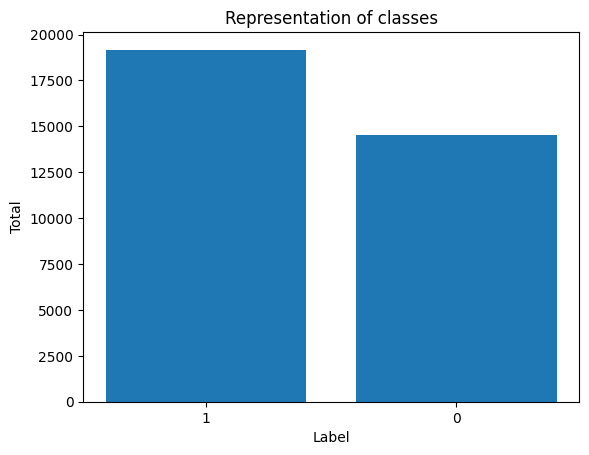

In [35]:
# Count the number of 1's in y_train
num_ones = np.count_nonzero(y_train_filtered == 1)

# Count the number of 0's in y_train
num_zeros = np.count_nonzero(y_train_filtered == 0)

print("Number of 1 in y_train_filtered:", num_ones)
print("Number of 0 in y_train_filtered:", num_zeros)

# Create the list of tags
labels = ['1', '0']

# Create the list of values
values = [num_ones, num_zeros]

# Create the graphic
plt.bar(labels, values)
plt.title("Representation of classes")
plt.xlabel("Label")
plt.ylabel("Total")
plt.show()

Number of 1 in y test filtered: 7104
Number of 0 in y test filtered: 7635


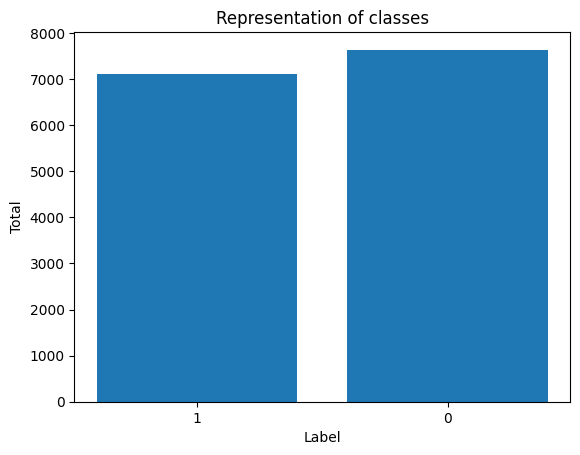

In [36]:
# Count the number of 1's in y_test
num_ones = np.count_nonzero(y_test_filtered == 1)

# Count the number of 0's in y_test
num_zeros = np.count_nonzero(y_test_filtered == 0)

print("Number of 1 in y test filtered:", num_ones)
print("Number of 0 in y test filtered:", num_zeros)

# Create the list of tags
labels = ['1', '0']

# Create the list of values
values = [num_ones, num_zeros]

# # Create the graphic
plt.bar(labels, values)
plt.title("Representation of classes")
plt.xlabel("Label")
plt.ylabel("Total")
plt.show()

Number of 1 in y val filtered: 827
Number of 0 in y val filtered: 881


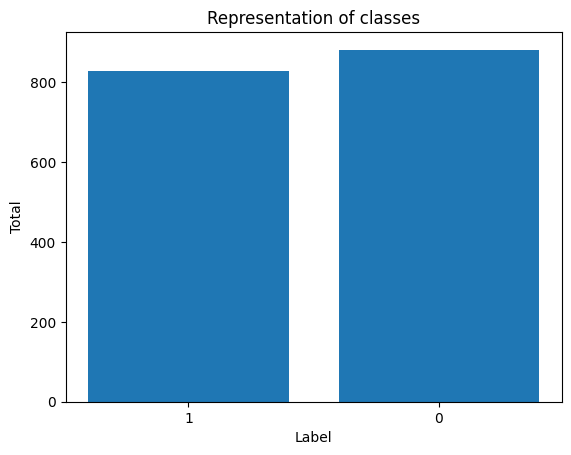

In [38]:
# Count the number of 1's in y_val
num_ones = np.count_nonzero(y_val_filtered == 1)

# Count the number of 0's in y_val
num_zeros = np.count_nonzero(y_val_filtered == 0)

print("Number of 1 in y val filtered:", num_ones)
print("Number of 0 in y val filtered:", num_zeros)

# Create the list of tags
labels = ['1', '0']

# Create the list of values
values = [num_ones, num_zeros]

# # Create the graphic
plt.bar(labels, values)
plt.title("Representation of classes")
plt.xlabel("Label")
plt.ylabel("Total")
plt.show()

##  2. 2. Random Forest

The random forest algorithm is made up of a collection of decision trees, and each tree in the ensemble is comprised of a data sample drawn from a training set with replacement, called the bootstrap sample. The model won’t overfit the model since the averaging of uncorrelated trees lowers the overall variance and prediction error.

In [39]:
# Reshape the training data
X_train_reshaped = X_train_filtered.reshape(33715, -1)

# Create Random Forest classifier
clf = RandomForestClassifier()

# Training the model with the reshaped training data
clf.fit(X_train_reshaped, y_train_filtered)

# Reshape the test data
X_test_reshaped = X_test_filtered.reshape(len(X_test_filtered), -1)

# Making predictions on test data
y_pred = clf.predict(X_test_reshaped)

# Calculate the accuracy of predictions
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Precisión del modelo: {:.2f}%".format(accuracy * 100))



<ipython-input-39-df5f84455353>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_reshaped, y_train_filtered)


Precisión del modelo: 76.71%


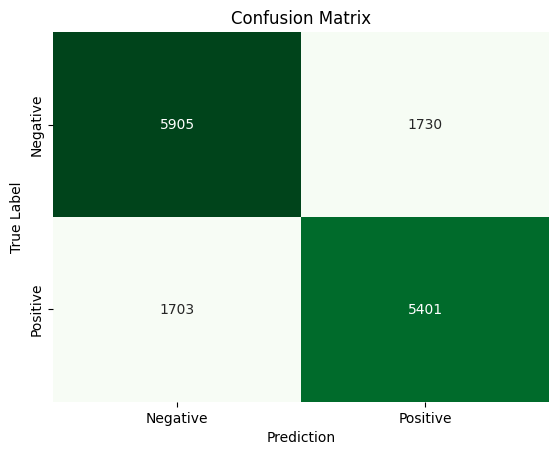

Accuracy: 76.71%
Recall: 76.03%
Specificity: 77.34%


In [40]:
fig, ax = plt.subplots()

# Calculate the confusion matrix
cm = confusion_matrix(y_test_filtered, y_pred)

# Display the confusion matrix as a heat map
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

# Add labels to x-axis ticks
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
# Add labels to y-axis ticks
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# Add title
ax.set_title('Confusion Matrix')

# Show the figure
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate recall
recall = recall_score(y_test_filtered, y_pred)
print("Recall: {:.2f}%".format(recall * 100))

# Calculate specificity
specificity = recall_score(y_test_filtered, y_pred, pos_label=0)
print("Specificity: {:.2f}%".format(specificity * 100))

In [41]:
# Calculate the value of F1
f1 = f1_score(y_test_filtered, y_pred)
print("Value F1: {:.2f}".format(f1))

Value F1: 0.76


AUC-ROC: 0.87


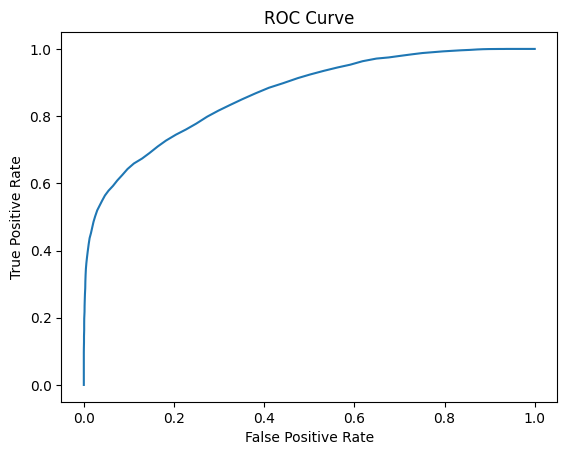

In [42]:
# Calculate the positive probability scores
y_scores = clf.predict_proba(X_test_reshaped)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_filtered, y_scores)

# Calculate the AUC-ROC
auc_roc = roc_auc_score(y_test_filtered, y_scores)
print("AUC-ROC: {:.2f}".format(auc_roc))

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

##  2. 3. Convolutional Neural Network

We normalize the data to increase the metrics.

In [43]:
# Define the desired shapes
desired_shape_train = (33715, 32, 39, 1)
desired_shape_test = (14739, 32, 39, 1)
desired_shape_val = (1708, 32, 39, 1)

# Create a StandardScaler object
scaler = StandardScaler()

# Reshape and normalize the training data
X_train_normalized = scaler.fit_transform(X_train_filtered.reshape(desired_shape_train[0], -1)).reshape(desired_shape_train)

# Reshape and normalize the test data
X_test_normalized = scaler.transform(X_test_filtered.reshape(desired_shape_test[0], -1)).reshape(desired_shape_test)

# Reshape and normalize the val data
X_val_normalized = scaler.transform(X_val_filtered.reshape(desired_shape_val[0], -1)).reshape(desired_shape_val)

###  2. 3. 1. Experiment 1

**Keras Tunner for model 1**

In [48]:
def build_model(hp):
    model = keras.Sequential()

    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                     padding='same',
                     activation=tf.keras.layers.LeakyReLU(alpha=0.001),
                     input_shape=(32,39,1)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     padding='same',
                     activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
                     padding='same',
                     activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=256, step=16),
                    activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('dense_2_units', min_value=32, max_value=512, step=16),
                    activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(hp.Float('dropout_5', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])



    return model


tuner = RandomSearch(
    build_model,
    objective=Objective("val_accuracy", direction="max"),
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

tuner.search(X_train_normalized, y_train_filtered, epochs=15, validation_data=(X_test_normalized, y_test_filtered))


Trial 5 Complete [00h 12m 38s]
val_accuracy: 0.9516023198763529

Best val_accuracy So Far: 0.9516023198763529
Total elapsed time: 01h 19m 12s


Obtain the best hiperparameters

In [49]:
print(tuner.get_best_hyperparameters(1))

In [50]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp)

In [51]:
tuner.results_summary()
best_models = tuner.get_best_models(num_models=1)
best_model = best_models[0]
best_model.summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
dropout_1: 0.1
conv_2_filter: 32
conv_2_kernel: 3
dropout_2: 0.4
conv_3_filter: 80
conv_3_kernel: 5
dropout_3: 0.4
dense_1_units: 80
dropout_4: 0.2
dense_2_units: 128
dropout_5: 0.1
learning_rate: 0.001
Score: 0.9516023198763529

Trial 3 summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
dropout_1: 0.30000000000000004
conv_2_filter: 48
conv_2_kernel: 3
dropout_2: 0.1
conv_3_filter: 112
conv_3_kernel: 3
dropout_3: 0.1
dense_1_units: 64
dropout_4: 0.0
dense_2_units: 448
dropout_5: 0.30000000000000004
learning_rate: 0.001
Score: 0.9381459554036459

Trial 1 summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
dropout_1: 0.4
conv_2_filter: 80
conv_2_kernel: 5
dropout_2: 0.4
conv_3_filter: 112
conv_3_kernel: 3
dropout_3: 0.30000000000000004
dense_1_units: 112
dropout_4: 0.30000000000000004
de

In [65]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

print("Mejores hiperparámetros:")
for hp_name, value in best_hps.values.items():
    print(f"{hp_name}: {value}")

print("\nResumen del mejor modelo:")
best_model.summary()

Mejores hiperparámetros:
conv_1_filter: 48
conv_1_kernel: 5
dropout_1: 0.1
conv_2_filter: 32
conv_2_kernel: 3
dropout_2: 0.4
conv_3_filter: 80
conv_3_kernel: 5
dropout_3: 0.4
dense_1_units: 80
dropout_4: 0.2
dense_2_units: 128
dropout_5: 0.1
learning_rate: 0.001

Resumen del mejor modelo:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 39, 48)        1248      
                                                                 
 dropout_12 (Dropout)        (None, 32, 39, 48)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 39, 32)        13856     
                                                                 
 dropout_13 (Dropout)        (None, 32, 39, 32)        0         
                                                                 
 conv2d_8 (Conv2D)          

In [66]:
best_trials = tuner.oracle.get_best_trials(num_trials=1)
best_trial = best_trials[0]
best_metric_value = best_trial.score

print("Best value of the objective metric:", best_metric_value)


Best value of the objective metric: 0.9516023198763529


**CNN construction**

In [69]:
#------------------CNN model 1---------------

# Crear el modelo secuencial
model = tf.keras.models.Sequential()

# Capa de convolución 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 39, 1)))
model.add(Dropout(0.3))

# Capa de convolución 2
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Dropout(0.1))

# Capa de convolución 3
model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Dropout(0.1))

# Capa de MaxPooling
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))

# Capa de aplanamiento
model.add(Flatten())

# Capa totalmente conectada 1
model.add(Dense(units=128))
model.add(Dropout(0.4))

# Capa totalmente conectada 2
model.add(Dense(units=80))
model.add(Dropout(0.1))

# Capa de salida
model.add(Dense(units=1, activation='sigmoid'))

# Imprimir un resumen del modelo
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 37, 32)        320       
                                                                 
 dropout_23 (Dropout)        (None, 30, 37, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 35, 32)        9248      
                                                                 
 dropout_24 (Dropout)        (None, 28, 35, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 33, 64)        18496     
                                                                 
 dropout_25 (Dropout)        (None, 26, 33, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 11, 64)       

In [70]:
# Compile the model with the optimal learning rate
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy', tf.metrics.Precision(), tf.metrics.Recall()])


In [71]:
cnn_model_history = model.fit(X_train_normalized, y_train_filtered, epochs=20, batch_size = 5, validation_data = (X_test_normalized, y_test_filtered))

Epoch 1/20
6743/6743 [==============================] - 45s 6ms/step - loss: 0.6256 - accuracy: 0.7201 - precision_3: 0.7402 - recall_3: 0.7825 - val_loss: 0.6739 - val_accuracy: 0.6582 - val_precision_3: 0.7194 - val_recall_3: 0.4768
Epoch 2/20
6743/6743 [==============================] - 43s 6ms/step - loss: 0.5279 - accuracy: 0.8041 - precision_3: 0.8309 - recall_3: 0.8230 - val_loss: 0.8963 - val_accuracy: 0.5352 - val_precision_3: 0.5095 - val_recall_3: 0.9557
Epoch 3/20
6743/6743 [==============================] - 42s 6ms/step - loss: 0.5084 - accuracy: 0.8196 - precision_3: 0.8504 - recall_3: 0.8285 - val_loss: 0.6518 - val_accuracy: 0.7144 - val_precision_3: 0.7416 - val_recall_3: 0.6253
Epoch 4/20
6743/6743 [==============================] - 41s 6ms/step - loss: 0.4997 - accuracy: 0.8248 - precision_3: 0.8540 - recall_3: 0.8346 - val_loss: 0.6185 - val_accuracy: 0.7075 - val_precision_3: 0.6961 - val_recall_3: 0.6978
Epoch 5/20
6743/6743 [==============================] - 41s 

Obtain the metrics

[0.6256022453308105, 0.5279134511947632, 0.5084389448165894, 0.4996717572212219, 0.49492591619491577, 0.4852673411369324, 0.48134011030197144, 0.4787328839302063, 0.4784744381904602, 0.46999427676200867, 0.4823983907699585, 0.4790154993534088, 0.4741799533367157, 0.47704699635505676, 0.4852956235408783, 0.4805152714252472, 0.4865407347679138, 0.4889872968196869, 0.4940982758998871, 0.48970216512680054]
[0.6738594174385071, 0.8962987065315247, 0.6518487334251404, 0.6184518933296204, 0.6010524034500122, 0.7414054274559021, 0.6031969785690308, 0.6431786417961121, 0.7556393146514893, 0.5711228251457214, 0.5745502710342407, 0.5504658818244934, 0.7838468551635742, 1.3721940517425537, 1.188372015953064, 0.7153433561325073, 0.5796037316322327, 0.9715263247489929, 1.2752339839935303, 0.8696572184562683]
[0.7200949192047119, 0.8040931224822998, 0.8196055293083191, 0.8247663974761963, 0.8294527530670166, 0.829749345779419, 0.8377873301506042, 0.8386178016662598, 0.8355331420898438, 0.842740595340

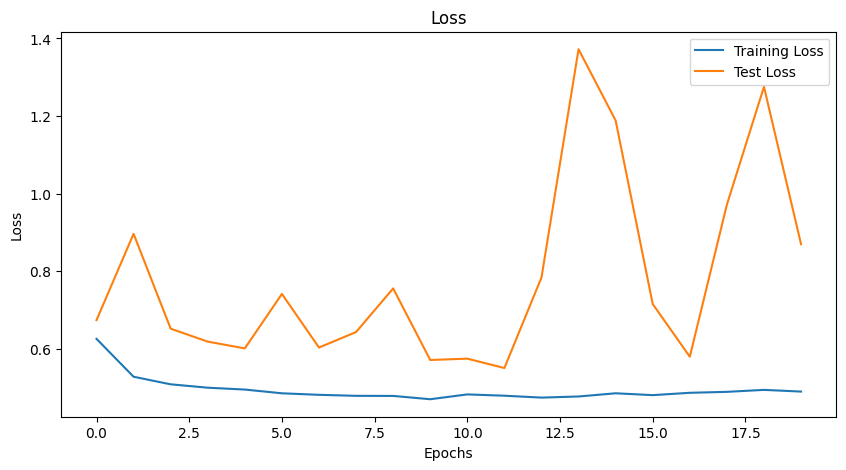

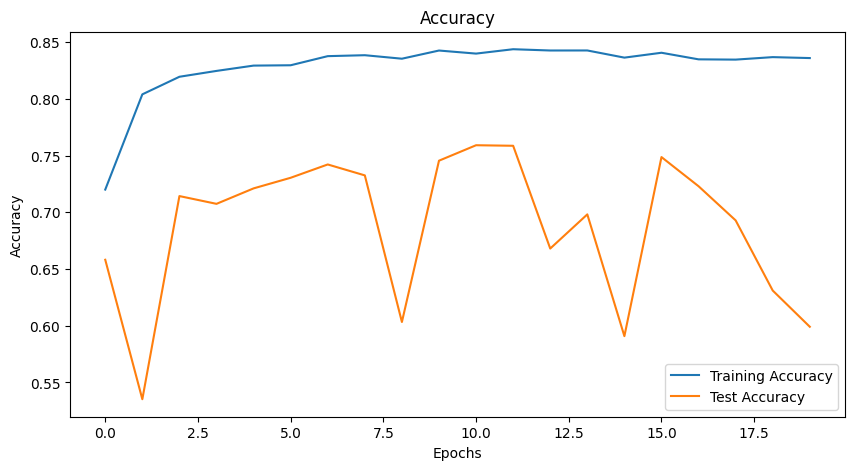

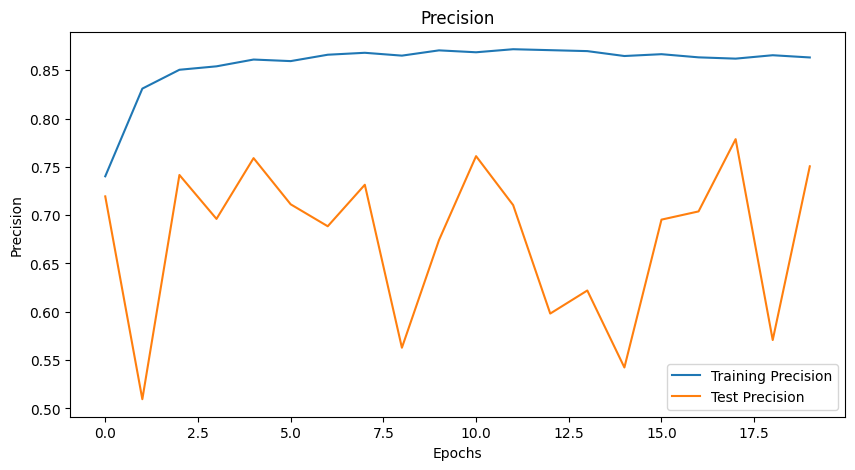

In [74]:
# Metrics
train_loss = cnn_model_history.history['loss']
val_loss = cnn_model_history.history['val_loss']
train_accuracy = cnn_model_history.history['accuracy']
val_accuracy = cnn_model_history.history['val_accuracy']
train_precision = cnn_model_history.history['precision_3']
val_precision = cnn_model_history.history['val_precision_3']

print(train_loss)
print(val_loss)
print(train_accuracy)
print(val_accuracy)
print(train_precision)
print(val_precision)
# Loss graphic
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy graphic
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Precision graphic
plt.figure(figsize=(10, 5))
plt.plot(train_precision, label='Training Precision')
plt.plot(val_precision, label='Test Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


Evaluate with the validation set

In [75]:
evaluation = model.evaluate(X_val_normalized, y_val_filtered)
print(evaluation)


54/54 [==============================] - 0s 5ms/step - loss: 0.9071 - accuracy: 0.5615 - precision_3: 0.7437 - recall_3: 0.1439
[0.9071242809295654, 0.561475396156311, 0.7437499761581421, 0.14389358460903168]


In [76]:
# STORE THE WEIGHTS
model.save('/content/drive/MyDrive/PESOS/experiment1.h5')


###  2. 3. 2. Experiment 2

**CNN construction**

In [80]:
# Create the sequential model
model2 = tf.keras.models.Sequential()

# Convolutional Layer 1
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 39, 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

# Convolutional Layer 2
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Convolutional Layer 3
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# Flatten Layer
model2.add(Flatten())

# Fully Connected Layer 1
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.4))

# Fully Connected Layer 2
model2.add(Dense(units=80, activation='relu'))
model2.add(Dropout(0.1))

# Output Layer
model2.add(Dense(units=1, activation='sigmoid'))

# Print a summary of the model
model2.summary()

# Compile the model with the optimal learning_rate value
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model2.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.metrics.Precision(), tf.metrics.Recall()])

# Fit the model to the training data
cnn_model_history = model2.fit(X_train_normalized, y_train_filtered, epochs=100, batch_size=5, validation_data=(X_test_normalized, y_test_filtered))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 37, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 30, 37, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 18, 32)       0         
 2D)                                                             
                                                                 
 dropout_29 (Dropout)        (None, 15, 18, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 13, 16, 32)      

[0.36788058280944824, 0.2663431167602539, 0.2308615744113922, 0.21032756567001343, 0.19788090884685516, 0.1853809356689453, 0.1783243715763092, 0.17001286149024963, 0.16282744705677032, 0.16080228984355927, 0.15507352352142334, 0.14838680624961853, 0.14703747630119324, 0.14525164663791656, 0.1400430053472519, 0.13825824856758118, 0.1339690387248993, 0.13285379111766815, 0.13176262378692627, 0.12852376699447632, 0.12536779046058655, 0.12678736448287964, 0.12542624771595, 0.12221565842628479, 0.1218511164188385, 0.12200437486171722, 0.12141337245702744, 0.12080539762973785, 0.11737324297428131, 0.11523176729679108, 0.11488130688667297, 0.11250261217355728, 0.1157621368765831, 0.112147755920887, 0.1152167096734047, 0.1092105433344841, 0.1110140010714531, 0.10768405348062515, 0.1063915267586708, 0.1055530309677124, 0.10561647266149521, 0.10629217326641083, 0.10841819643974304, 0.10258212685585022, 0.10401706397533417, 0.10026618838310242, 0.10590330511331558, 0.101216159760952, 0.102564103

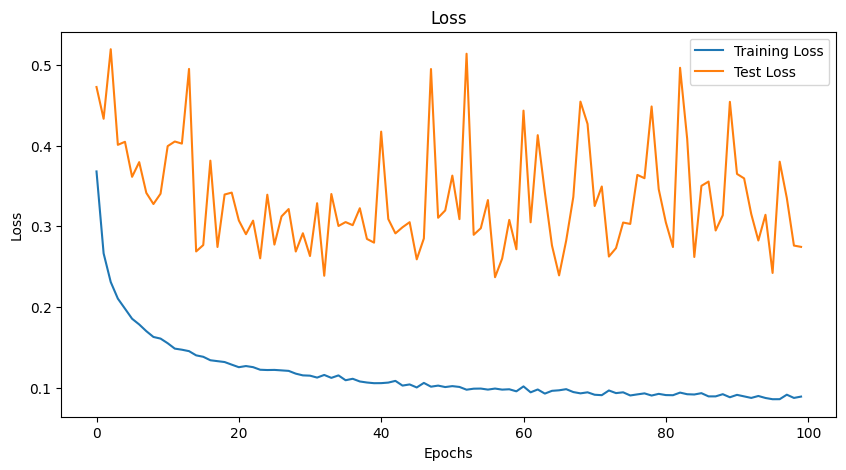

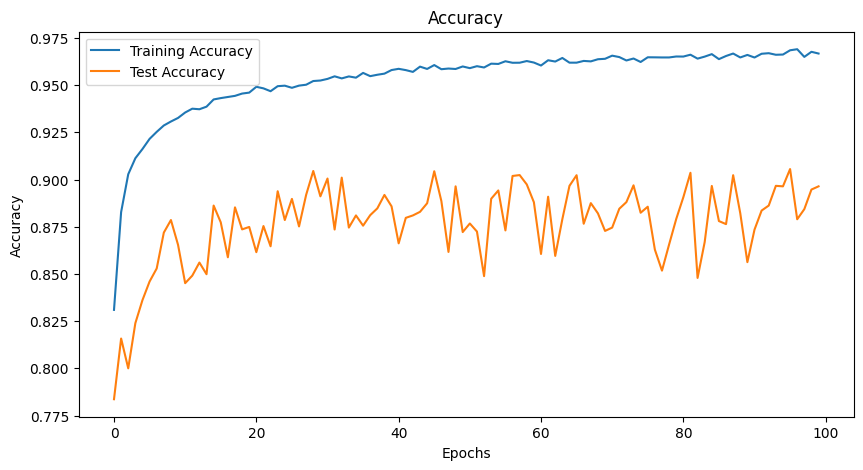

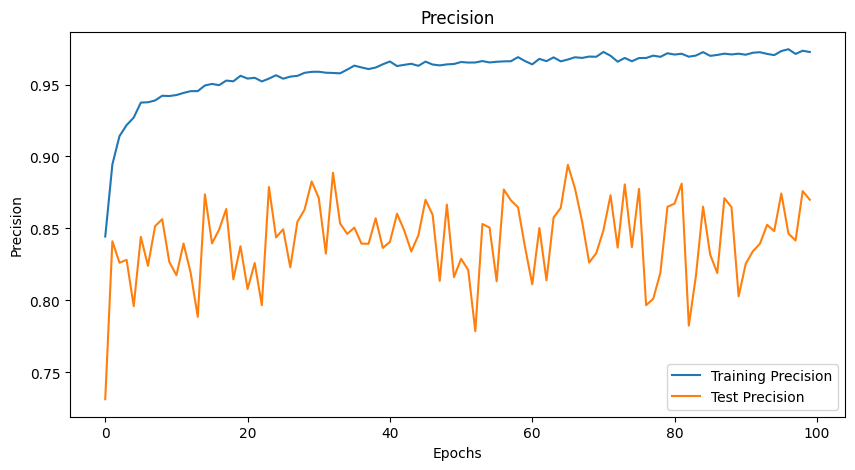

In [81]:
# Metrics
train_loss = cnn_model_history.history['loss']
val_loss = cnn_model_history.history['val_loss']
train_accuracy = cnn_model_history.history['accuracy']
val_accuracy = cnn_model_history.history['val_accuracy']
train_precision = cnn_model_history.history['precision_4']
val_precision = cnn_model_history.history['val_precision_4']

print(train_loss)
print(val_loss)
print(train_accuracy)
print(val_accuracy)
print(train_precision)
print(val_precision)
# Loss graphic
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy graphic
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Precision graphic
plt.figure(figsize=(10, 5))
plt.plot(train_precision, label='Training Precision')
plt.plot(val_precision, label='Test Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [82]:
evaluation = model.evaluate(X_val_normalized, y_val_filtered)
print(evaluation)


54/54 [==============================] - 0s 4ms/step - loss: 0.9071 - accuracy: 0.5615 - precision_3: 0.7437 - recall_3: 0.1439
[0.9071242809295654, 0.561475396156311, 0.7437499761581421, 0.14389358460903168]


In [83]:
# STORE THE WEIGHTS
model.save('/content/drive/MyDrive/PESOS/experiment2.h5')